# Calculate a 2D emissions grid incorporating COVID-19 effects for short-lived forcers

In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import reverse_geocoder as rg
import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time

In [2]:
input_folder = "../input/aerosols/"
output_folder = "../output/aerosols/"

# Input for the aerosols/gases
input_nox = "NOx-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_bc = "BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_so2 = "SO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_oc = "OC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_co = "CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nh3 = "NH3-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nmvoc = "NMVOC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_blip = "Robin_sectors_V3.csv"
convert_country_code_file = "convertCountryCodes.csv"
files_to_blip = [
    input_co, 
    input_nh3, input_nmvoc,
    input_oc, input_so2, input_nox, input_bc
]
key_variables = [
    "CO_em_anthro", 
    "NH3_em_anthro", "NMVOC_em_anthro",
    "OC_em_anthro", "SO2_em_anthro", "NOx_em_anthro", "BC_em_anthro"
]
# The name to affix on the variables output
scenario_string = "test.nc"

def convert_years_to_days(year):
    return (year - 2015) * 365

# We don't want data after 2050. Data is recorded in 365-day years
tcutoff = convert_years_to_days(2050.99)
# We apply a uniform rate to discount some time period between flatrate_start and flatrate_end
flatrate_start =  convert_years_to_days(2020.5)
flatrate_end =  convert_years_to_days(2022)

# We want to add timepoints in these years: 
years_to_add = [2019, 2021, 2023]

In [3]:
# More inputs for the long-term path modification
# Modification factors found at:
mod_input_folder = "../../COVID19_emissions_data/global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

# Map between key variable name and excel column
path_var_names = {
    "SO2_em_anthro": "sox(MtS/year)",  
    "CO_em_anthro": "co(Mt/year)", 
    "NMVOC_em_anthro": "nmvoc(Mt/year)",
    "NOx_em_anthro": "nox(MtN/year)",
    "BC_em_anthro": "bc(Mt/year)",
    "OC_em_anthro":"oc(Mt/year)", 
    "NH3_em_anthro": "nh3(Mt/year)"
}

pathway_files = [mod_input_ff, mod_input_2yr, mod_input_mg, mod_input_sg]

modify_range = np.arange(2022, 2051.01)

In [4]:
assert len(files_to_blip) == len(key_variables) # check input

## Collect and clean the data
We need to make the blip factors consistent with the netCDF data structure. This will require example data, although the results should not depend which example is chosen. 

In [5]:
nox_0 = nc.Dataset(input_folder + input_nox, "r", format="NETCDF4")
blip_factors = pd.read_csv(input_folder + input_blip)
convert_countries = pd.read_csv(input_folder + convert_country_code_file, keep_default_na=False, na_values=['_'])

In [6]:
data_to_modify = [nox_0]

In [7]:
for dimobj in nox_0.dimensions.values():
...     print(dimobj)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 360
<class 'netCDF4._netCDF4.Dimension'>: name = 'sector', size = 8
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 120
<class 'netCDF4._netCDF4.Dimension'>: name = 'bound', size = 2


In [8]:
nox_0.variables["sector"]

<class 'netCDF4._netCDF4.Variable'>
int32 sector(sector)
    long_name: sector
    bounds: sector_bnds
    ids: 0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping
unlimited dimensions: 
current shape = (8,)
filling on, default _FillValue of -2147483647 used

In [9]:
blip_factors = blip_factors[~blip_factors["1"].isna()]
blip_sectors = blip_factors["Sector"].unique()

## Perform the sector weighting


In [10]:
blip_sectors

array(['surface-transport', 'residential', 'public/commercial',
       'industry', 'international-shipping', 'international-aviation',
       'domestic-aviation', 'power'], dtype=object)

The set of sectors in our blip need to be converted into our sectors in the netCDF case. This uses:
0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping

In [11]:
sector_dict = {"surface-transport": 3, "residential": 4, "public/commercial": -4, "industry": 2, 
 "international-shipping":7, "international-aviation": -1, "domestic-aviation": -2, "power": 1}
sectors_to_use = [1, 2, 3, 4, 5, 7]  # We will manage sectors 6 and 7 elsewhere, no change to sector 0 (agri).

In [12]:
blip_factors_multi = blip_factors.copy()
blip_factors_multi.drop(["Country", "Base(MtCO2/day)", "Unnamed: 0"], axis=1, inplace=True)
blip_factors_multi["Sector"] = [sector_dict[sect] for sect in blip_factors_multi["Sector"]]
blip_factors_multi.head()

,ISO_A3,Sector,Base%,1,2,3,4,5,6,7,...,357,358,359,360,361,362,363,364,365,366
0,ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
2,AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
3,ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
4,ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
blip_factors_multi.set_index(blip_factors_multi.columns[:2].to_list(), drop=True, inplace=True)
blip_factors_multi.head()

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# We want to average the two sets of sector 4 together in the right ratio
all_countries = blip_factors_multi.index.get_level_values("ISO_A3").unique()
for country in all_countries:
    if (country, 4) in blip_factors_multi.index and (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = (
            blip_factors_multi.loc[country, 4].values * 
            blip_factors_multi["Base%"][country, 4] + 
            blip_factors_multi.loc[country, -4].values * blip_factors_multi["Base%"][country, -4]
            ) / (
                blip_factors_multi["Base%"][country, 4] + blip_factors_multi["Base%"][country, -4]
            )
        blip_factors_multi["Base%"][country, 4] = blip_factors_multi["Base%"][country, 4] + \
            blip_factors_multi["Base%"][country, -4]
        blip_factors_multi.drop((country, -4), inplace=True)
    elif (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = blip_factors_multi.loc[country, -4]
    elif (country, 4) in blip_factors_multi.index:
        continue
    else:
        print("no data for {}".format(country))

In [15]:
# Test that this produces the right answers
example_factor = blip_factors[
    (blip_factors["ISO_A3"] == "GBR") & (blip_factors["Sector"].isin(["residential", "public/commercial"]))
][["Base%", "100"]]
assert np.isclose(blip_factors_multi.loc["GBR", 4][100], sum(
    example_factor["Base%"] * example_factor["100"]) / sum(example_factor["Base%"])
)

In [16]:
blip_factors_multi

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,1,43.093385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102
VNM,1,31.822661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964
YEM,1,34.652509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565


We additionally assume that solvent production tracks industry.

In [17]:
for country in all_countries:
    blip_factors_multi.loc[(country, 5), :] = blip_factors_multi.loc[(country, 4), :]

In [18]:
blip_factors_multi.index.levels

FrozenList([['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'CUB', 'CUW', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GRC', 'GTM', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LBN', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MEX', 'MKD', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MUS', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', ...], [-4, -2, -1, 1, 2, 3, 4, 7, 5]])

## Derive country and date relation
We need to assign each lat/long a country. This is slightly complicated by the country index being 2 letters in the inverse geocoder but 3 letters in our data.

In [19]:
lat, lon = nox_0.variables["lat"][:], nox_0.variables["lon"][:]

In [20]:
convert_countries_dict = {convert_countries["A2 (ISO)"][i]: convert_countries["A3 (UN)"][i] for i in convert_countries.index}
coords = []
lon_length = len(lon)
for latperm in lat:
    coords = coords + list(zip([latperm] * lon_length, lon))

In [21]:
results = rg.search(coords)

Loading formatted geocoded file...


In [22]:
lat_countries_dict = {coords[i]: convert_countries_dict[results[i]["cc"]] for i in range(len(coords)) 
                      if results[i]["cc"] in convert_countries_dict.keys()}

The process will be faster if we map the other way and use the index rather than the coordinates:

In [23]:
country_coord_dict = {}
for k, v in lat_countries_dict.items():
    country_coord_dict[v] = country_coord_dict.get(v, [])
    country_coord_dict[v].append((np.where(lat.data == k[0])[0][0], np.where(lon.data == k[1])[0][0]))

Now we must relate the dates. blip_factors uses days from 2020-01-01, and has values for every day. The netCDFs use days since 2015-01-01, which is 5 * 365 days later and monthly. (The netcdf does not leap days)

In [24]:
date_dif = 5 * 365
date_dif

1825

In [25]:
netCDF_times = nox_0.variables["time"][:]
netCDF_tseries = pd.Series(netCDF_times)
bliptimes = blip_factors_multi.columns[blip_factors_multi.columns != "Base%"]
bliptimes = pd.Series(pd.to_numeric(bliptimes))

In [26]:
time_dict = {}
remaining_times = bliptimes.copy()
mappable_times = netCDF_tseries[(netCDF_tseries > date_dif) & (netCDF_tseries < date_dif + max(bliptimes))]
for t in mappable_times.index[:-1]:
    closeTimes = [bliptime for bliptime in remaining_times if (
        0.5 * (mappable_times[t + 1] + mappable_times[t]) - date_dif > bliptime
    )]
    time_dict[mappable_times[t]] = closeTimes
    remaining_times = remaining_times[~remaining_times.isin(closeTimes)]
time_dict[mappable_times.iloc[-1]] = list(remaining_times)

In [27]:
blip_factors_av = pd.DataFrame(index=blip_factors_multi.index, columns=time_dict.keys())
for key, val in time_dict.items():
    blip_factors_av[key] = blip_factors_multi[list(str(v) for v in val)].mean(axis=1)

In [28]:
def insert_year_of_data(year, data):
    for i in range(1,13):
        insert_interpolated_point(data, (year - 2015) * 365 + data.variables["time"][(i - 1)], 12, i)

## Prepare long-term adjustments
We will adjust dates after 2021 to represent a long-term change in trend. This will rely on the difference between a baseline path and a specific path. 

In [29]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=1, sheet_name="Emissions")
baseline

,Unnamed: 0,co2_fossil(GtC/year),co2_land(GtC/year),ch4(Mt/year),n2o(Mt(N2)/year),sox(MtS/year),co(Mt/year),nmvoc(Mt/year),nox(MtN/year),bc(Mt/year),...,mcf(kt/year),hcfc22(kt/year),hcfc141b(kt/year),hcfc142b(kt/year),halon1211(kt/year),halon1202(kt/year),halon1301(kt/year),halon2402(kt/year),ch3br(kt/year),ch3cl(kt/year)
year,,,,,,,,,,,,,,,,,,,,,
1765.041667,0,0.003017,0.106683,20.916467,0.072541,1.248525,352.784696,60.597387,3.877079,2.123054,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.125000,1,0.003050,0.106850,20.911000,0.072655,1.247975,352.488688,60.533163,3.877638,2.121962,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.208333,2,0.003083,0.107017,20.905533,0.072769,1.247425,352.192679,60.468937,3.878196,2.120871,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.291667,3,0.003117,0.107183,20.900067,0.072883,1.246875,351.896671,60.404712,3.878754,2.119779,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.375000,4,0.003150,0.107350,20.894600,0.072997,1.246325,351.600662,60.340488,3.879313,2.118688,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050.625000,3427,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,54.809500,25.770750,1.883250,0.274500,0.0,0.189375,0.001375,155.925,3511.082
2050.708333,3428,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,54.163167,25.659917,1.870083,0.272833,0.0,0.188625,0.001292,155.925,3511.082
2050.791667,3429,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,53.516833,25.549083,1.856917,0.271167,0.0,0.187875,0.001208,155.925,3511.082


In [30]:
month_dict = {i: baseline.index[i] - 1765 for i in range(12)}
def make_day_into_year(days):
    return 2015 + days // 365 + month_dict[(days % 365) // 30]
make_day_into_year( 365 * 6 + 2)

2021.041666666667

## Perform the emissions blip
We now have a mapping between times and locations and the emissions we want. 

In [31]:
all_valid_countries = [c for c in all_countries if c in country_coord_dict.keys()]
monthly_range = [
    date for date in nox_0.variables["time"][:] if (date >= convert_years_to_days(min(modify_range)))
    and (date < convert_years_to_days(max(modify_range)))
]
monthly_range

[5490.0,
 5520.0,
 5549.0,
 5580.0,
 5610.0,
 5641.0,
 5671.0,
 5702.0,
 5733.0,
 5763.0,
 5794.0,
 5824.0,
 9140.0,
 9170.0,
 9199.0,
 9230.0,
 9260.0,
 9291.0,
 9321.0,
 9352.0,
 9383.0,
 9413.0,
 9444.0,
 9474.0,
 12790.0,
 12820.0,
 12849.0,
 12880.0,
 12910.0,
 12941.0,
 12971.0,
 13002.0,
 13033.0,
 13063.0,
 13094.0,
 13124.0]

In [32]:
nox_0.close()
varrate_timeinds = [ind for ind in blip_factors_av.columns if ind < flatrate_start]

In [ ]:
for fileind in range(len(files_to_blip)):
    file = files_to_blip[fileind]
    data = copy_netcdf_file(file, input_folder, output_folder, scenario_string)
    print("Working on data for {}".format(key_variables[fileind]))
    # Insert interpolated points in 2019, 2021 and 2023.
    for year_to_add in years_to_add:
        insert_year_of_data(year_to_add, data)
    output = data.variables[key_variables[fileind]][:, :, :, :]
    plt.figure(figsize=(16, 8))
    plt.plot(data.variables["time"][:]/365 + 2015, output[:,  3, 262, 605])
    print("Added years {}".format(years_to_add))
    flatrate_timeinds = np.where((data.variables["time"][:] <= flatrate_end) & (data.variables["time"][:] >= flatrate_start))[0]
    # Modify points by a time-and country dependent value in 2020 - 2021
    for country in ["CHN"]: # all_valid_countries:   #TODO: change this
        print(country)
        for time in varrate_timeinds:
            timeind = np.where(data.variables["time"][:] == time)[0]
            for sector in sectors_to_use:
                try:
                    mult_fact = blip_factors_av[time].loc[country, sector] + 1
                    if mult_fact != 1.0: #This saves operations
                        for lati, longi in country_coord_dict[country]:
                            output[timeind, sector, lati, longi] *= mult_fact
                except KeyError as e:
                    continue
        # Then make the changes for all of the flat rate times (same factor)
        timeinds = flatrate_timeinds
        for sector in sectors_to_use:
            try:
                mult_fact = blip_factors_av[-1].loc[country, sector] + 1
                if mult_fact != 1.0: #This saves operations
                    for lati, longi in country_coord_dict[country]:
                        output[timeinds, sector, lati, longi] *= mult_fact
            except KeyError as e:
                continue
    data.variables[key_variables[fileind]][:, :, :, :] = output
    data.close()
    for pathind in range(len(pathway_files)):
        path_file = pathway_files[pathind]
        path_string = path_file.split("_")[0] + ".nc"
        print("Adding path for {}".format(path_string))
        data = copy_netcdf_file(file + scenario_string, output_folder, output_folder, "_")
        output = data.variables[key_variables[fileind]][:, :, :, :]
        path_df = pd.read_excel(mod_input_folder + path_file, header=0, index_col=1, sheet_name="Emissions")
        for time in monthly_range:
            timeind = np.where(data.variables["time"][:] == time)
            time_factor = path_df[path_var_names[key_variables[fileind]]].loc[
                make_day_into_year(time)
            ] / baseline[path_var_names[key_variables[fileind]]].loc[make_day_into_year(time)]
            output[timeind, ...] = (output[timeind, :]) * time_factor 
        plt.plot(
            data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605], linestyle ="-."
        )
        data.variables[key_variables[fileind]][:, :, :, :] = output
        data.close()
        print("Cutting the end off of {}".format(path_string))
        data = cutoff_netcdf_time(
            output_folder, output_folder, file + scenario_string + "_", tcutoff, scenario_string=path_string
        )
        data.close()

Working on data for CO_em_anthro
Added years [2019, 2021, 2023]
CHN
Adding path for FossilFuel.nc
Cutting the end off of FossilFuel.nc
Adding path for TwoYearBlip.nc
Cutting the end off of TwoYearBlip.nc
Adding path for ModerateGreen.nc
Cutting the end off of ModerateGreen.nc


## SANDBOX
Code below this line will break, but may be useful to use in some order to understand the data. 

In [34]:
blob  # unassigned variable stops execution

NameError: name 'blob' is not defined

In [ ]:
data.close()

In [ ]:
for pathind in [2]:
    path_file = pathway_files[pathind]
    path_string = path_file.split("_")[0] + ".nc"
    data = copy_netcdf_file(file + scenario_string, output_folder, output_folder, "__")
    output = data.variables[key_variables[fileind]][:, :, :, :]
    path_df = pd.read_excel(mod_input_folder + path_file, header=0, index_col=1, sheet_name="Emissions")

In [ ]:
plt.plot(data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605])
for time in monthly_range:
    timeind = np.where(data.variables["time"][:] == time)
    time_factor = path_df[path_var_names[key_variables[fileind]]].loc[
        make_day_into_year(time)
    ] / baseline[path_var_names[key_variables[fileind]]].loc[make_day_into_year(time)]
    output[timeind, ...] = (output[timeind, :]) * time_factor 
plt.plot(data.variables["time"][:]/365 + 2015, data.variables[key_variables[fileind]][:,  2, 262, 605])


In [36]:
monthly_range

[5490.0,
 5520.0,
 5549.0,
 5580.0,
 5610.0,
 5641.0,
 5671.0,
 5702.0,
 5733.0,
 5763.0,
 5794.0,
 5824.0,
 9140.0,
 9170.0,
 9199.0,
 9230.0,
 9260.0,
 9291.0,
 9321.0,
 9352.0,
 9383.0,
 9413.0,
 9444.0,
 9474.0,
 12790.0,
 12820.0,
 12849.0,
 12880.0,
 12910.0,
 12941.0,
 12971.0,
 13002.0,
 13033.0,
 13063.0,
 13094.0,
 13124.0]

In [ ]:
file + scenario_string

In [ ]:
monthly_range = [date for date in data.variables["time"][:] if date >= convert_years_to_days(min(modify_range)) 
 and date < convert_years_to_days(max(modify_range))]

In [39]:
file

'BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc'

In [ ]:
fileind = 0
file = files_to_blip[fileind]
pathind = 2
path_file = pathway_files[pathind]
path_string = path_file.split("_")[0] + ".nc"

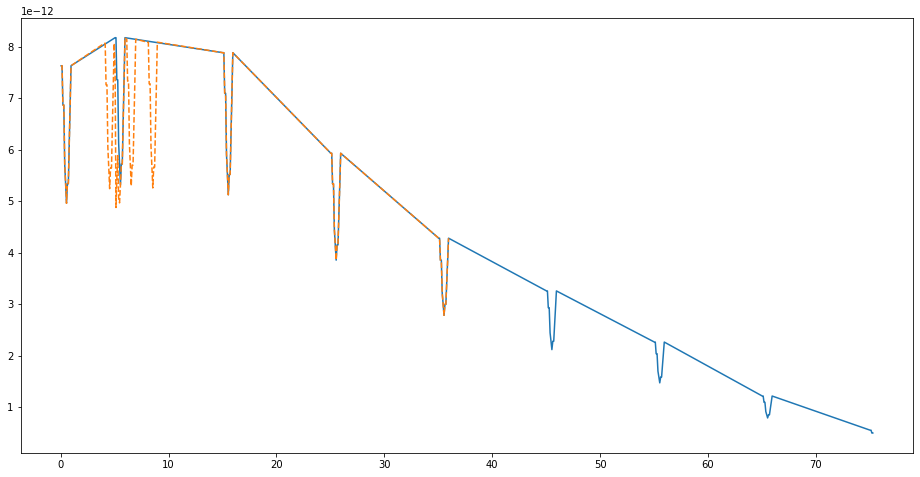

In [35]:
plt.figure(figsize=(16, 8))
data = nc.Dataset(input_folder + file)
plt.plot(data.variables["time"][:100] / 365, data.variables[key_variables[fileind]][:100, 2, 262, 605])
data = nc.Dataset(output_folder +"cut_" + file + scenario_string + "_" + path_string)
plt.plot(data.variables["time"][:100] / 365, data.variables[key_variables[fileind]][:100, 2, 262, 605], linestyle= "--")


In [ ]:
for i in range(2,12):
    insert_interpolated_point(data, 4*365 + 15 + 1 + (i - 1) * 30, 12, i)

In [ ]:
nox_0.variables["time_bnds"][-1, 0] / 365

In [ ]:
def arrays_equal(a, b):
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True

In [ ]:
np.where(data.variables[key_variables[fileind]][:, :, :, :] == data.variables[key_variables[fileind]][:, :, :, :].max())

In [ ]:
co2_0 = nc.Dataset(input_co2_mole)